# Collegamento Drive

In [ ]:
!df -h /content/drive

df: /content/drive: No such file or directory


In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

!ls '/content/drive/My Drive/SonART/'

Mounted at /content/drive
audio_prova.mp3			Fog-Horn.wav			   river-26984.mp3
birds-chirping-75156.mp3	mar-calmado-272997.mp3		   saved_model
city-street-downtown-52115.mp3	ocean-cruise-liner-ship-32308.mp3  sea-and-seagull-wave-5932.mp3
Code				ProjectMPT_DEFINITIVO1.mp3	   seagull-sound-effect-272695.mp3
Demo				prova2_2.wav			   sea-waves-169411.mp3
Fog_Horn.mp3			prova3_2.wav			   ship-engine-32705.mp3


# IMPORT

In [2]:
!pip install torchlibrosa

In [3]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import librosa
import torch

In [4]:
path = "/content/drive/MyDrive/SonART/Code/panns_inference"
if os.path.exists(path):
    print("La cartella esiste!")
else:
    print("Errore: La cartella non è stata trovata. Controlla il percorso.")

La cartella esiste!


In [5]:
sys.path.append("/content/drive/MyDrive/SonART/Code/panns_inference")

In [7]:
from panns_inference import AudioTagging, SoundEventDetection, labels

# CREAZIONE MODELLO E CARICAMENTO SUL DRIVE

In [8]:
def print_audio_tagging_result(clipwise_output):
    """Visualization of audio tagging result.

    Args:
      clipwise_output: (classes_num,)
    """
    sorted_indexes = np.argsort(clipwise_output)[::-1]

    # Print audio tagging top probabilities
    for k in range(10):
        print('{}: {:.3f}'.format(np.array(labels)[sorted_indexes[k]],
            clipwise_output[sorted_indexes[k]]))

In [9]:
def plot_sound_event_detection_result(framewise_output):
    """Visualization of sound event detection result.

    Args:
      framewise_output: (time_steps, classes_num)
    """
    out_fig_path = 'results/sed_result.png'
    os.makedirs(os.path.dirname(out_fig_path), exist_ok=True)

    #Calcola il valore massimo di attivazione per ciascuna classe su tutti i frame
    classwise_output = np.max(framewise_output, axis=0) # (classes_num,)

    idxes = np.argsort(classwise_output)[::-1]
    idxes = idxes[0:8]

    ix_to_lb = {i : label for i, label in enumerate(labels)}
    lines = []
    for idx in idxes:
        line, = plt.plot(framewise_output[:, idx], label=ix_to_lb[idx])
        lines.append(line)

    plt.legend(handles=lines)
    plt.xlabel('Frames')
    plt.ylabel('Probability')
    plt.ylim(0, 1.)
    plt.savefig(out_fig_path)
    print('Save fig to {}'.format(out_fig_path))

------ Audio tagging ------
Checkpoint path: /content/drive/My Drive/SonART/saved_model/panns/Cnn14_mAP=0.431.pth
✅ La cartella esiste già: /content/drive/My Drive/SonART/saved_model/panns
✅ Il file esiste già, nessun download necessario.
💾 Modello istanziato salvato su Drive: /content/drive/My Drive/SonART/saved_model/panns/panns_model.pth
GPU number: 1
Frog: 0.150
Stream: 0.133
Animal: 0.109
Duck: 0.091
Water: 0.083
Quack: 0.071
Gurgling: 0.068
Bird: 0.052
Liquid: 0.046
Trickle, dribble: 0.041
------ Sound event detection ------
Checkpoint path: /content/drive/My Drive/SonART/saved_model/panns/Cnn14_DecisionLevelMax.pth
✅ La cartella esiste già: /content/drive/My Drive/SonART/saved_model/panns
✅ Il file esiste già, nessun download necessario.
💾 Modello istanziato salvato su Drive: /content/drive/My Drive/SonART/saved_model/panns/panns_model_event_det.pth
GPU number: 1
Save fig to results/sed_result.png


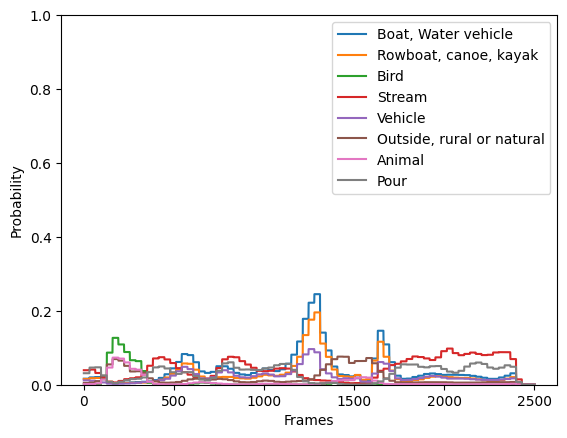

In [38]:
device = 'cuda' # 'cuda' | 'cpu'
audio_path = "/content/drive/My Drive/SonART/prova3_2.wav"
(audio, _) = librosa.core.load(audio_path, sr=32000, mono=True)
audio = audio[None, :]  # (batch_size, segment_samples)

print('------ Audio tagging ------')
at = AudioTagging(model=None, checkpoint_path=None, device=device)
(clipwise_output, embedding) = at.inference(audio)
"""clipwise_output: (batch_size, classes_num), embedding: (batch_size, embedding_size)"""

print_audio_tagging_result(clipwise_output[0])

print('------ Sound event detection ------')
sed = SoundEventDetection(
    checkpoint_path=None,
    device=device,
    interpolate_mode='nearest', # 'nearest'
)
framewise_output = sed.inference(audio)
"""(batch_size, time_steps, classes_num)"""

plot_sound_event_detection_result(framewise_output[0])

In [27]:
def get_active_classes_per_frame(framewise_output, labels=None, threshold=0.3):

    #Calcola il valore massimo di attivazione per ciascuna classe su tutti i frame
    classwise_output = np.max(framewise_output, axis=0) # (classes_num,)

    idxes = np.argsort(classwise_output)[::-1]
    idxes = idxes[0:8]

    ix_to_lb = {i : label for i, label in enumerate(labels)}


In [60]:
sorted_indexes = np.argsort(framewise_output, axis=-1)[:, -1 : -5 - 1 : -1]
print(sorted_indexes)
print(sorted_indexes.shape)

[[[ 12 281 207 ... 506 137   0]
  [ 12 281 207 ... 506 137   0]
  [ 12 281 207 ... 506 137   0]
  [ 12 281 207 ... 506 137   0]
  [ 12 281 207 ... 506 137   0]]]
(1, 5, 527)
527


TypeError: only integer scalar arrays can be converted to a scalar index

In [40]:
#Calcola il valore massimo di attivazione per ciascuna classe su tutti i frame
classwise_output = np.max(framewise_output, axis=0) # (classes_num,)

idxes = np.argsort(classwise_output)[::-1]
idxes = idxes[0:8]

ix_to_lb = {i : label for i, label in enumerate(labels)}

#for idx in idxes:
    #label = ix_to_lb[int(idx)]  # Convertiamo idx in un intero
    #print(label)

print(idxes.shape)
print(idxes)

(8, 527)
[[ 12 281 207 ... 506 137   0]
 [ 12 281 207 ... 506 137   0]
 [ 12 281 207 ... 506 137   0]
 ...
 [ 12 281 207 ... 506 137   0]
 [ 12 281 207 ... 506 137   0]
 [ 12 281 207 ... 506 137   0]]


In [53]:
print(classwise_output.shape)
print(classwise_output)

(2504, 527)
[[5.5580395e-03 9.5349700e-05 3.2948061e-05 ... 1.5045825e-05
  1.5734726e-05 1.5067983e-05]
 [5.5580395e-03 9.5349700e-05 3.2948061e-05 ... 1.5045825e-05
  1.5734726e-05 1.5067983e-05]
 [5.5580395e-03 9.5349700e-05 3.2948061e-05 ... 1.5045825e-05
  1.5734726e-05 1.5067983e-05]
 ...
 [1.5743431e-03 3.2226487e-06 3.0031549e-06 ... 3.8429666e-06
  8.8966942e-07 3.8657122e-06]
 [1.5743431e-03 3.2226487e-06 3.0031549e-06 ... 3.8429666e-06
  8.8966942e-07 3.8657122e-06]
 [1.5743431e-03 3.2226487e-06 3.0031549e-06 ... 3.8429666e-06
  8.8966942e-07 3.8657122e-06]]


In [28]:
active_classes_per_frame = get_active_classes_per_frame(framewise_output[0], labels=labels)

In [29]:
print(active_classes_per_frame)

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [],

# RECUPERA MODELLO DAL DRIVE

In [46]:
# Percorso del modello su Drive
checkpoint_path = "/content/drive/My Drive/SonART/saved_model/panns/panns_model.pth"

# Carica il modello salvato
model = torch.load(checkpoint_path, map_location="cuda" if torch.cuda.is_available() else "cpu", weights_only=False)

# Modello base ottimizzato

In [42]:
def best_tag(clipwise_output):
    """Visualization of audio tagging result.

    Args:
      clipwise_output: (classes_num,)
    """
    sorted_indexes = np.argsort(clipwise_output)[::-1]

    return sorted_indexes[0]

In [43]:
audio_path = "/content/drive/My Drive/SonART/prova3_2.wav"
(audio, _) = librosa.core.load(audio_path, sr=32000, mono=True)

In [44]:
# **Specifica la durata dei segmenti in secondi**
segment_duration = 3 # Durata del segmento in secondi (esempio: 2 secondi)
hop_duration = 1   # Durata del salto tra segmenti in secondi (esempio: 1 secondo)

# Calcolare la lunghezza di ogni segmento in campioni
segment_length = int(segment_duration * 32000)
hop_length = int(hop_duration * 32000)

# Dividere il waveform in segmenti con il salto specificato
segments = []
for start in range(0, len(audio) - segment_length + 1, hop_length):
    segment = audio[start:start + segment_length]
    segments.append(segment)

# Aggiungere l'ultimo segmento se non coperto dal ciclo (padding se necessario)
if len(audio) % hop_length != 0:
    last_segment = audio[-segment_length:]
    segments.append(last_segment)

# Trasformare i segmenti in un array numpy
segments = np.stack(segments)

# Mostrare dettagli
print(f"Numero di segmenti: {len(segments)}, Forma di ogni segmento: {segments[0].shape}")

Numero di segmenti: 24, Forma di ogni segmento: (96000,)


In [47]:
tag_list = []
device = 'cuda' # 'cuda' | 'cpu'
at = AudioTagging(model=model, checkpoint_path='/content/drive/My Drive/SonART/saved_model/panns/Cnn14_mAP=0.431.pth', device=device)

Checkpoint path: /content/drive/My Drive/SonART/saved_model/panns/Cnn14_mAP=0.431.pth
✅ La cartella esiste già: /content/drive/My Drive/SonART/saved_model/panns
✅ Il file esiste già, nessun download necessario.
Il modello esiste già!
GPU number: 1


In [48]:
for segment in segments:
  segment = segment[None, :]  # (batch_size, segment_samples)

  #at = AudioTagging(model=model, checkpoint_path='/content/drive/My Drive/SonART/saved_model/panns/Cnn14_mAP=0.431.pth', device=device)
  (clipwise_output, embedding) = at.inference(segment)
  """clipwise_output: (batch_size, classes_num), embedding: (batch_size, embedding_size)"""

  index = best_tag(clipwise_output[0])
  predicted_class = np.array(labels)[index]
  clipwise_output = clipwise_output[0]


  print('{}: {:.3f}'.format(predicted_class,clipwise_output[index]))
  tag_list.append(predicted_class)

Stream: 0.142
Whistling: 0.126
Stream: 0.226
Stream: 0.151
Stream: 0.147
Goose: 0.311
Duck: 0.234
Stream: 0.227
Stream: 0.278
Stream: 0.201
Stream: 0.205
Rowboat, canoe, kayak: 0.257
Rowboat, canoe, kayak: 0.407
Rowboat, canoe, kayak: 0.249
Walk, footsteps: 0.175
Animal: 0.125
Stream: 0.199
Stream: 0.133
Stream: 0.217
Stream: 0.229
Stream: 0.159
Stream: 0.120
Rain: 0.056
Rain: 0.048


# Versione DEMO ottimizzata

In [52]:
# Variabile per tracciare la parola precedentemente stampata
last_printed_word = None
# Variabile per tracciare la parola precedente all'iterazione attuale
previous_word = None

tag_list = []

for segment in segments:
  segment = segment[None, :]  # (batch_size, segment_samples)

  (clipwise_output, embedding) = at.inference(segment)
  """clipwise_output: (batch_size, classes_num), embedding: (batch_size, embedding_size)"""

  index = best_tag(clipwise_output[0])
  predicted_class = np.array(labels)[index]
  clipwise_output = clipwise_output[0]

  # Stampa solo se la parola si ripete almeno 2 volte di fila e non è la stessa della precedente
  if predicted_class == previous_word:
      if predicted_class != last_printed_word:
          if(clipwise_output[index] >= 0.400):
            print('{}: {:.3f}'.format(predicted_class,
            clipwise_output[index]))
            tag_list.append(predicted_class)
            last_printed_word = predicted_class  # Aggiorna l'ultima parola stampata
  else:
      previous_word = predicted_class  # Aggiorna la parola precedente solo se non è la stessa


Rowboat, canoe, kayak: 0.407


In [41]:
from IPython.display import Audio
Audio(audio, rate=32000)